In [1]:
from keras.datasets import mnist

from keras.layers import Input , Dense , Reshape , Flatten , Dropout
from keras.layers import BatchNormalization , Activation , ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D , Conv2D

from keras.models import Sequential , Model

from keras.optimizers import Adam


C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import numpy as np
import os

In [4]:
import sys

In [5]:
#=====
WIDTH = 96
HEIGHT = 96
CHANNEL = 3

LATENT_DIM = 100 #latent variable z

BATCH_SIZE = 64
EPOCHS = 10

PATH = 'faces/'

load_index = 0

images_name = os.listdir(PATH)

IMAGES_COUNT = len(images_name)

In [6]:
#========
def load_image(batch_size = BATCH_SIZE):
    global load_index
    
    images = []
    
    for i in range(batch_size):
        images.append(matplotlib.image.imread(PATH + images_name[(load_index + i) % IMAGES_COUNT]))
    
    load_index += batch_size
    
    return np.array(images)

In [7]:
class GAN(object):
    
    def __init__(self):
        self.img_rows = 96
        self.img_cols = 96
        self.channels = 3 #black and white
        
        self.img_shape = (self.img_rows , self.img_cols , self.channels)
        self.latent_dim = 100 #z dimension 100
        
        optimizer = Adam(lr=0.0002 , beta_1=0.5)
        
        #构造 判别器
        self.discriminator = self.build_discriminator()
        #判别器
        self.discriminator.compile(loss='binary_crossentropy',
                                  optimizer=optimizer , metrics=['accuracy'])
        
        
        #构造 生成器
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim , ))
        #使用噪音生成一个图像
        img = self.generator(z)
        
        #在combined的整体模型中 将判别器固定起来 不进行训练
        self.discriminator.trainable = False
        
        #使用判别器判断利用噪音生成的图像的真假
        validity = self.discriminator(img) #因为判别器最后一层是sigmoid 所以返回一个0-1之间的实数
        
        self.combines = Model(z , validity)
        self.combines.compile(loss='binary_crossentropy' , optimizer=optimizer)
        
    def build_discriminator(self):
        model = Sequential()
        
        model.add(Flatten(input_shape = self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dense(1 , activation='sigmoid'))
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img , validity)
    
    def build_generator(self):
        model = Sequential()
        #从100维的噪音中生成出来
        model.add(Dense(256 , input_dim=self.latent_dim))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape) , activation='tanh')) #构造同尺寸的图片
        model.add(Reshape(self.img_shape)) #Flatten的逆操作
        
        noise = Input(shape=(self.latent_dim,)) #100 dimension
        img = model(noise)
        
        return Model(noise , img)
    

    def train(self , epochs , sample_internal=50):
        X_train=load_image()
        
        X_train = X_train/127.5 - 1
        #X_train = np.expand_dims(X_train , axis=3)
        
        valid = np.ones((BATCH_SIZE , 1)) #real img
        fake = np.ones((BATCH_SIZE , 1)) #fake img
        
        for epoch in range(epochs):
            #in paper
            #训练判别器
            #idx = np.random.randint(0 , X_train.shape[0] , size=BATCH_SIZE) #随机的batch
            #imgs = X_train[idx]
            
            noise = np.random.normal(0,1,size=(BATCH_SIZE , self.latent_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            #d_loss_real = self.discriminator.train_on_batch(imgs , valid)
            d_loss_real = self.discriminator.train_on_batch(X_train , valid)

            d_loss_fake = self.discriminator.train_on_batch(gen_imgs , fake)
            
            d_loss = 0.5 * np.add(d_loss_real , d_loss_fake)
            
            
            #训练生成器
            noise = np.random.normal(0,1,size=(BATCH_SIZE , self.latent_dim))
            
            g_loss = self.combines.train_on_batch(noise , valid)
            
            print('%d Discriminator loss%f acc%f Generator loss%f' % (epoch , d_loss[0] , d_loss[1] , g_loss))
            
            if epoch%sample_internal == 0:
                self.sample_images(epoch)
        
    def sample_images(self , epoch):
        r , c = 5 , 5
        noise = np.random.normal(0,1,size=(r*c , self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        gen_imgs = (gen_imgs+1)*127.5
        
        fig , axs = plt.subplots(r,c)
        
        cnt = 0
        
        for i in range(r):
            for j in range(c):
                axs[i][j].imshow(gen_imgs[cnt , :,:,0])# , cmap=plt.cm.gray)
                axs[i][j].axis('off')
                
                cnt+=1
        
        fig.savefig('No.%d.png' % epoch)
        #plt.show()
        plt.close()

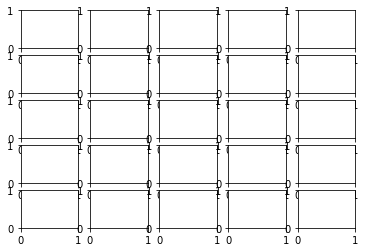

In [12]:
#fig , axs = plt.subplots(5,5)

In [ ]:
gan = GAN()

In [ ]:
gan.train(epochs=20000 , sample_internal=100)

C:\Anaconda3\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 Discriminator loss0.838729 acc0.515625 Generator loss0.703804
1 Discriminator loss0.340548 acc0.921875 Generator loss0.423403
2 Discriminator loss0.093988 acc0.992188 Generator loss0.202395
3 Discriminator loss0.046103 acc0.992188 Generator loss0.088179
4 Discriminator loss0.020085 acc1.000000 Generator loss0.039539
5 Discriminator loss0.020908 acc0.992188 Generator loss0.021583
6 Discriminator loss0.011277 acc1.000000 Generator loss0.017197
7 Discriminator loss0.004887 acc1.000000 Generator loss0.010577
8 Discriminator loss0.002810 acc1.000000 Generator loss0.006868
9 Discriminator loss0.002806 acc1.000000 Generator loss0.004682
10 Discriminator loss0.001462 acc1.000000 Generator loss0.004847
11 Discriminator loss0.001668 acc1.000000 Generator loss0.004933
12 Discriminator loss0.001924 acc1.000000 Generator loss0.003705
13 Discriminator loss0.001712 acc1.000000 Generator loss0.002889
14 Discriminator loss0.000922 acc1.000000 Generator loss0.002752
15 Discriminator loss0.001750 acc1.

127 Discriminator loss0.000052 acc1.000000 Generator loss0.000145
128 Discriminator loss0.000069 acc1.000000 Generator loss0.000150
129 Discriminator loss0.000063 acc1.000000 Generator loss0.000133
130 Discriminator loss0.000071 acc1.000000 Generator loss0.000186
131 Discriminator loss0.000079 acc1.000000 Generator loss0.000201
132 Discriminator loss0.000076 acc1.000000 Generator loss0.000102
133 Discriminator loss0.000087 acc1.000000 Generator loss0.000114
134 Discriminator loss0.000073 acc1.000000 Generator loss0.000100
135 Discriminator loss0.000079 acc1.000000 Generator loss0.000098
136 Discriminator loss0.000080 acc1.000000 Generator loss0.000142
137 Discriminator loss0.000040 acc1.000000 Generator loss0.000160
138 Discriminator loss0.000050 acc1.000000 Generator loss0.000089
139 Discriminator loss0.000055 acc1.000000 Generator loss0.000111
140 Discriminator loss0.000084 acc1.000000 Generator loss0.000098
141 Discriminator loss0.000045 acc1.000000 Generator loss0.000094
142 Discri

252 Discriminator loss0.000020 acc1.000000 Generator loss0.000042
253 Discriminator loss0.000023 acc1.000000 Generator loss0.000045
254 Discriminator loss0.000026 acc1.000000 Generator loss0.000034
255 Discriminator loss0.000016 acc1.000000 Generator loss0.000033
256 Discriminator loss0.000018 acc1.000000 Generator loss0.000050
257 Discriminator loss0.000016 acc1.000000 Generator loss0.000057
258 Discriminator loss0.000021 acc1.000000 Generator loss0.000062
259 Discriminator loss0.000023 acc1.000000 Generator loss0.000050
260 Discriminator loss0.000022 acc1.000000 Generator loss0.000043
261 Discriminator loss0.000022 acc1.000000 Generator loss0.000047
262 Discriminator loss0.000021 acc1.000000 Generator loss0.000042
263 Discriminator loss0.000031 acc1.000000 Generator loss0.000018
264 Discriminator loss0.000024 acc1.000000 Generator loss0.000031
265 Discriminator loss0.000020 acc1.000000 Generator loss0.000042
266 Discriminator loss0.000036 acc1.000000 Generator loss0.000046
267 Discri

379 Discriminator loss0.000010 acc1.000000 Generator loss0.000016
380 Discriminator loss0.000014 acc1.000000 Generator loss0.000027
381 Discriminator loss0.000013 acc1.000000 Generator loss0.000029
382 Discriminator loss0.000015 acc1.000000 Generator loss0.000033
383 Discriminator loss0.000013 acc1.000000 Generator loss0.000014
384 Discriminator loss0.000011 acc1.000000 Generator loss0.000024
385 Discriminator loss0.000021 acc1.000000 Generator loss0.000026
386 Discriminator loss0.000015 acc1.000000 Generator loss0.000034
387 Discriminator loss0.000011 acc1.000000 Generator loss0.000027
388 Discriminator loss0.000017 acc1.000000 Generator loss0.000017
389 Discriminator loss0.000009 acc1.000000 Generator loss0.000020
390 Discriminator loss0.000018 acc1.000000 Generator loss0.000032
391 Discriminator loss0.000012 acc1.000000 Generator loss0.000020
392 Discriminator loss0.000011 acc1.000000 Generator loss0.000017
393 Discriminator loss0.000011 acc1.000000 Generator loss0.000033
394 Discri

504 Discriminator loss0.000007 acc1.000000 Generator loss0.000042
505 Discriminator loss0.000007 acc1.000000 Generator loss0.000017
506 Discriminator loss0.000009 acc1.000000 Generator loss0.000013
507 Discriminator loss0.000006 acc1.000000 Generator loss0.000019
508 Discriminator loss0.000008 acc1.000000 Generator loss0.000015
509 Discriminator loss0.000007 acc1.000000 Generator loss0.000010
510 Discriminator loss0.000010 acc1.000000 Generator loss0.000017
511 Discriminator loss0.000007 acc1.000000 Generator loss0.000024
512 Discriminator loss0.000006 acc1.000000 Generator loss0.000011
513 Discriminator loss0.000006 acc1.000000 Generator loss0.000018
514 Discriminator loss0.000008 acc1.000000 Generator loss0.000008
515 Discriminator loss0.000008 acc1.000000 Generator loss0.000012
516 Discriminator loss0.000006 acc1.000000 Generator loss0.000016
517 Discriminator loss0.000007 acc1.000000 Generator loss0.000015
518 Discriminator loss0.000011 acc1.000000 Generator loss0.000013
519 Discri

631 Discriminator loss0.000006 acc1.000000 Generator loss0.000012
632 Discriminator loss0.000004 acc1.000000 Generator loss0.000008
633 Discriminator loss0.000008 acc1.000000 Generator loss0.000009
634 Discriminator loss0.000003 acc1.000000 Generator loss0.000009
635 Discriminator loss0.000003 acc1.000000 Generator loss0.000008
636 Discriminator loss0.000006 acc1.000000 Generator loss0.000009
637 Discriminator loss0.000005 acc1.000000 Generator loss0.000011
638 Discriminator loss0.000005 acc1.000000 Generator loss0.000013
639 Discriminator loss0.000005 acc1.000000 Generator loss0.000014
640 Discriminator loss0.000003 acc1.000000 Generator loss0.000007
641 Discriminator loss0.000004 acc1.000000 Generator loss0.000010
642 Discriminator loss0.000007 acc1.000000 Generator loss0.000006
643 Discriminator loss0.000004 acc1.000000 Generator loss0.000009
644 Discriminator loss0.000008 acc1.000000 Generator loss0.000011
645 Discriminator loss0.000004 acc1.000000 Generator loss0.000010
646 Discri

758 Discriminator loss0.000003 acc1.000000 Generator loss0.000005
759 Discriminator loss0.000004 acc1.000000 Generator loss0.000016
760 Discriminator loss0.000003 acc1.000000 Generator loss0.000008
761 Discriminator loss0.000003 acc1.000000 Generator loss0.000005
762 Discriminator loss0.000006 acc1.000000 Generator loss0.000007
763 Discriminator loss0.000002 acc1.000000 Generator loss0.000009
764 Discriminator loss0.000006 acc1.000000 Generator loss0.000008
765 Discriminator loss0.000003 acc1.000000 Generator loss0.000005
766 Discriminator loss0.000002 acc1.000000 Generator loss0.000006
767 Discriminator loss0.000003 acc1.000000 Generator loss0.000005
768 Discriminator loss0.000004 acc1.000000 Generator loss0.000006
769 Discriminator loss0.000003 acc1.000000 Generator loss0.000006
770 Discriminator loss0.000005 acc1.000000 Generator loss0.000008
771 Discriminator loss0.000005 acc1.000000 Generator loss0.000006
772 Discriminator loss0.000004 acc1.000000 Generator loss0.000006
773 Discri

884 Discriminator loss0.000005 acc1.000000 Generator loss0.000005
885 Discriminator loss0.000006 acc1.000000 Generator loss0.000005
886 Discriminator loss0.000002 acc1.000000 Generator loss0.000004
887 Discriminator loss0.000003 acc1.000000 Generator loss0.000011
888 Discriminator loss0.000002 acc1.000000 Generator loss0.000007
889 Discriminator loss0.000002 acc1.000000 Generator loss0.000007
890 Discriminator loss0.000003 acc1.000000 Generator loss0.000006
891 Discriminator loss0.000003 acc1.000000 Generator loss0.000003
892 Discriminator loss0.000002 acc1.000000 Generator loss0.000008
893 Discriminator loss0.000004 acc1.000000 Generator loss0.000005
894 Discriminator loss0.000004 acc1.000000 Generator loss0.000009
895 Discriminator loss0.000003 acc1.000000 Generator loss0.000010
896 Discriminator loss0.000002 acc1.000000 Generator loss0.000004
897 Discriminator loss0.000005 acc1.000000 Generator loss0.000007
898 Discriminator loss0.000004 acc1.000000 Generator loss0.000006
899 Discri